# Impact of Academic Factors on Final Grades

## Data Cleaning/Preparation

### Independent Variables: 
**school** - student's school (binary: "GP" - Gabriel Pereira or "MS" - Mousinho da Silveira) <br>
**studytime** - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours) <br>
**failures** - number of past class failures (numeric: n if 1<=n<3, else 4) <br>
**schoolsup** - extra educational support (binary: yes or no) <br>
**famsup** - family educational support (binary: yes or no) <br>
**paid** - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no) <br>
**higher** - wants to take higher education (binary: yes or no)<br>

### Dependent Variables: 
**G1** - first period grade (numeric: from 0 to 20) <br>
**G2** - second period grade (numeric: from 0 to 20) <br>
**G3** - final grade (numeric: from 0 to 20, output target) <br>

In [1]:
# Import libraries
import pandas as pd
import math
from matplotlib import gridspec
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
# Read in the datasets
students_mat = pd.read_csv('../dataset/student-mat.csv', delimiter=';')
students_por = pd.read_csv('../dataset/student-por.csv', delimiter=';')

# Merge common students
mat_students_merged = students_mat.merge(students_por[["school","sex","age","address","famsize","Pstatus","Medu","Fedu","Mjob","Fjob","reason","nursery","internet"]])
por_students_merged = students_por.merge(students_mat[["school","sex","age","address","famsize","Pstatus","Medu","Fedu","Mjob","Fjob","reason","nursery","internet"]])

# Filter out for academic features
mat_students = mat_students_merged[['school', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'higher', 'G1', 'G2', 'G3']]
por_students = por_students_merged[['school', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'higher', 'G1', 'G2', 'G3']]

In [3]:
print("mat shape:", mat_students.shape[0]) # shape of datasets
print("por shape:", por_students.shape[0])

mat shape: 382
por shape: 382


In [4]:
mat_students.head(3) # View the math dataset

,school,studytime,failures,schoolsup,famsup,paid,higher,G1,G2,G3
0,GP,2,0,yes,no,no,yes,5,6,6
1,GP,2,0,no,yes,no,yes,5,5,6
2,GP,2,3,yes,no,yes,yes,7,8,10


In [5]:
por_students.head(3) # View the por dataset

,school,studytime,failures,schoolsup,famsup,paid,higher,G1,G2,G3
0,GP,2,0,yes,no,no,yes,0,11,11
1,GP,2,0,no,yes,no,yes,9,11,11
2,GP,2,0,yes,no,no,yes,12,13,12


In [6]:
# Create a dictionary mapping 'yes' to 1 and 'no' to 0
mapping = {'yes': 1, 'no': 0, 'GP': 1, 'MS': 0}

mat_students['school'] = mat_students['school'].replace(mapping)
por_students['school'] = por_students['school'].replace(mapping)

mat_students['schoolsup'] = mat_students['schoolsup'].replace(mapping)
mat_students['famsup'] = mat_students['famsup'].replace(mapping)
mat_students['paid'] = mat_students['paid'].replace(mapping)
mat_students['higher'] = mat_students['higher'].replace(mapping)
por_students['schoolsup'] = por_students['schoolsup'].replace(mapping)
por_students['famsup'] = por_students['famsup'].replace(mapping)
por_students['paid'] = por_students['paid'].replace(mapping)
por_students['higher'] = por_students['higher'].replace(mapping)

C:\Users\zuzal\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\zuzal\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\zuzal\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [7]:
mat_students.head(3) # View the por dataset

,school,studytime,failures,schoolsup,famsup,paid,higher,G1,G2,G3
0,1,2,0,1,0,0,1,5,6,6
1,1,2,0,0,1,0,1,5,5,6
2,1,2,3,1,0,1,1,7,8,10


In [8]:
por_students.head(3) # View the por dataset

,school,studytime,failures,schoolsup,famsup,paid,higher,G1,G2,G3
0,1,2,0,1,0,0,1,0,11,11
1,1,2,0,0,1,0,1,9,11,11
2,1,2,0,1,0,0,1,12,13,12


In [9]:
mat_students.describe().applymap('{:,.2f}'.format).T # descriptive statistics for mat class

,count,mean,std,min,25%,50%,75%,max
school,382.00,0.90,0.31,0.00,1.00,1.00,1.00,1.00
studytime,382.00,2.03,0.85,1.00,1.00,2.00,2.00,4.00
failures,382.00,0.29,0.73,0.00,0.00,0.00,0.00,3.00
schoolsup,382.00,0.13,0.34,0.00,0.00,0.00,0.00,1.00
famsup,382.00,0.62,0.49,0.00,0.00,1.00,1.00,1.00
paid,382.00,0.46,0.50,0.00,0.00,0.00,1.00,1.00
higher,382.00,0.95,0.21,0.00,1.00,1.00,1.00,1.00
G1,382.00,10.86,3.35,3.00,8.00,10.50,13.00,19.00
G2,382.00,10.71,3.83,0.00,8.25,11.00,13.00,19.00
G3,382.00,10.39,4.69,0.00,8.00,11.00,14.00,20.00


In [10]:
por_students.describe().applymap('{:,.2f}'.format).T # descriptive statistics for por class

,count,mean,std,min,25%,50%,75%,max
school,382.00,0.90,0.31,0.00,1.00,1.00,1.00,1.00
studytime,382.00,2.04,0.85,1.00,1.00,2.00,2.00,4.00
failures,382.00,0.14,0.51,0.00,0.00,0.00,0.00,3.00
schoolsup,382.00,0.13,0.34,0.00,0.00,0.00,0.00,1.00
famsup,382.00,0.63,0.48,0.00,0.00,1.00,1.00,1.00
paid,382.00,0.07,0.25,0.00,0.00,0.00,0.00,1.00
higher,382.00,0.95,0.21,0.00,1.00,1.00,1.00,1.00
G1,382.00,12.11,2.56,0.00,10.00,12.00,14.00,19.00
G2,382.00,12.24,2.47,5.00,11.00,12.00,14.00,19.00
G3,382.00,12.52,2.95,0.00,11.00,13.00,14.00,19.00


In [11]:
columns = ['studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'higher']  # independent variables
n_plots = len(columns) 

# Plot frequency distributions for each independent variable
def plot_variables(table):
    gs = gridspec.GridSpec(3, 3)
    fig = plt.figure(figsize=(12,8))
    for i in range(n_plots):
        ax = fig.add_subplot(gs[i])
        table[columns[i]].value_counts().sort_index().plot(kind='bar', ax=ax, edgecolor='black')
        ax.set_xlabel(columns[i])
        ax.set_ylabel('Count')
        ax.set_title('Histogram for variable: ' + columns[i])
    fig.tight_layout()
    plt.show()

MAT STUDENTS


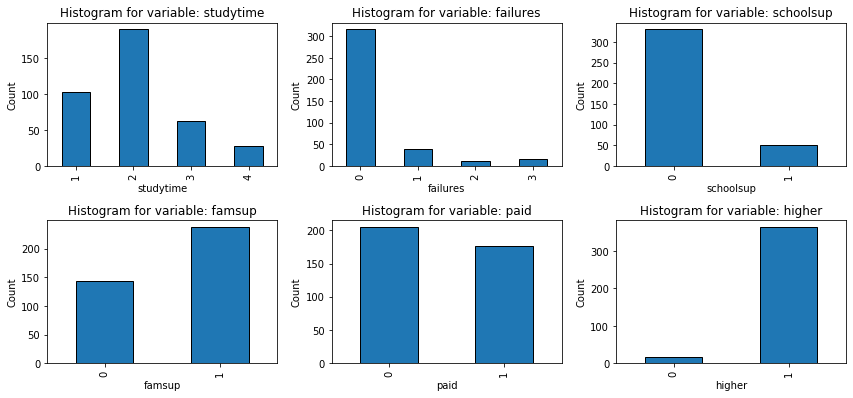

POR STUDENTS


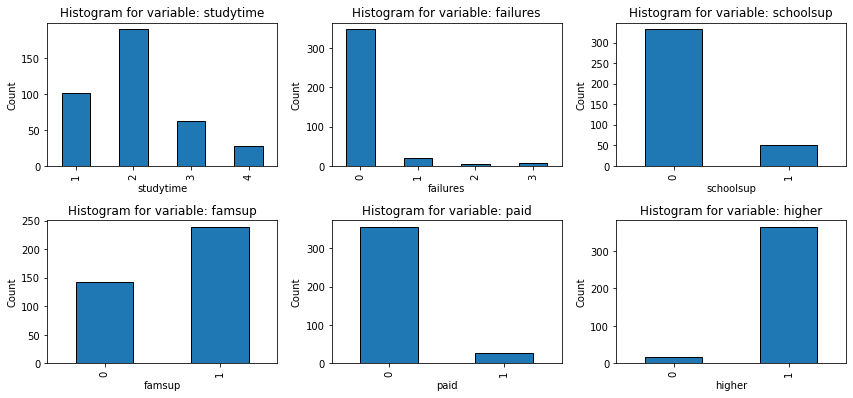

In [12]:
print('MAT STUDENTS')
plot_variables(mat_students)
print('POR STUDENTS')
plot_variables(por_students)

In [13]:
mat_students['paid'].value_counts() # value counts for paid in mat class

0    205
1    177
Name: paid, dtype: int64

In [14]:
por_students['paid'].value_counts() # value counts for paid in por class

0    356
1     26
Name: paid, dtype: int64

### Impact of Study Time on Grades

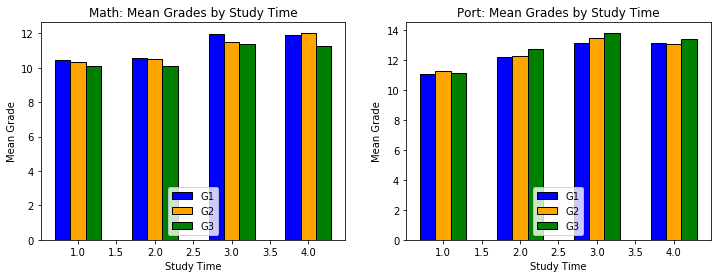

In [15]:
# Plot grouped bar charts for study time vs mean grades
gs = gridspec.GridSpec(1, 2)
fig = plt.figure(figsize=(12,4))
width = 0.2
studytime = [1, 2, 3, 4]

# Math class
ax = fig.add_subplot(gs[0])
for x in studytime:
    y1 = mat_students.loc[mat_students['studytime'] == x]['G1'].mean()
    y2 = mat_students.loc[mat_students['studytime'] == x]['G2'].mean()
    y3 = mat_students.loc[mat_students['studytime'] == x]['G3'].mean()
    plt.bar(x-width, y1, width, color='blue', edgecolor='black') 
    plt.bar(x, y2, width, color='orange', edgecolor='black') 
    plt.bar(x+width, y3, width, color='green', edgecolor='black') 
plt.legend(["G1", "G2", "G3"], loc='lower center') 
ax.set_xlabel('Study Time')
ax.set_ylabel('Mean Grade')
ax.set_title("Math: Mean Grades by Study Time")

# Port class
ax = fig.add_subplot(gs[1])
for x in studytime:
    y1 = por_students.loc[por_students['studytime'] == x]['G1'].mean()
    y2 = por_students.loc[por_students['studytime'] == x]['G2'].mean()
    y3 = por_students.loc[por_students['studytime'] == x]['G3'].mean()
    plt.bar(x-width, y1, width, color='blue', edgecolor='black') 
    plt.bar(x, y2, width, color='orange', edgecolor='black') 
    plt.bar(x+width, y3, width, color='green', edgecolor='black') 
plt.legend(["G1", "G2", "G3"], loc='lower center') 
ax.set_xlabel('Study Time')
ax.set_ylabel('Mean Grade')
ax.set_title("Port: Mean Grades by Study Time")

plt.show()

#### Significance Testing Using Chi-Squared Test

In [16]:
columns.append('school') # include school in correlation matrix

In [17]:
mat_students[columns].corr()

,studytime,failures,schoolsup,famsup,paid,higher,school
studytime,1.000000,-0.198990,0.029744,0.159236,0.161443,0.184467,0.084631
failures,-0.198990,1.000000,0.023038,-0.023408,-0.197673,-0.369164,-0.004424
schoolsup,0.029744,0.023038,1.000000,0.082983,-0.025172,0.014643,0.134242
famsup,0.159236,-0.023408,0.082983,1.000000,0.267807,0.081949,0.157394
paid,0.161443,-0.197673,-0.025172,0.267807,1.000000,0.181856,0.009156
higher,0.184467,-0.369164,0.014643,0.081949,0.181856,1.000000,0.004648
school,0.084631,-0.004424,0.134242,0.157394,0.009156,0.004648,1.000000


In [18]:
por_students[columns].corr()

,studytime,failures,schoolsup,famsup,paid,higher,school
studytime,1.000000,-0.200304,0.027910,0.151267,-0.024875,0.185895,0.086774
failures,-0.200304,1.000000,0.044395,-0.039946,0.128251,-0.324302,-0.072483
schoolsup,0.027910,0.044395,1.000000,0.091692,0.049211,0.013041,0.132719
famsup,0.151267,-0.039946,0.091692,1.000000,0.101653,0.083265,0.159462
paid,-0.024875,0.128251,0.049211,0.101653,1.000000,0.011043,-0.043368
higher,0.185895,-0.324302,0.013041,0.083265,0.011043,1.000000,0.004648
school,0.086774,-0.072483,0.132719,0.159462,-0.043368,0.004648,1.000000


In [19]:
# Define chi-square test function
def create_chisquare_test_table(alpha= 0.05):
    data = []
    cross_tabs = [pd.crosstab(mat_students['studytime'], mat_students['G1']), 
              pd.crosstab(mat_students['studytime'], mat_students['G2']),
              pd.crosstab(mat_students['studytime'], mat_students['G3']),
              pd.crosstab(por_students['studytime'], por_students['G1']),
              pd.crosstab(por_students['studytime'], por_students['G2']),
              pd.crosstab(por_students['studytime'], por_students['G3'])]
    gradeCounter = 1
    for i in range(0,len(cross_tabs)):
        if gradeCounter == 4:
            gradeCounter = 1
        stat, p_value, dof, expected = chi2_contingency(cross_tabs[i], correction=False)
        data.append(['Math' if i < 3 else 'Port', 'G'+str(gradeCounter), round(p_value, 2), '*' if p_value < 0.05 else ''])
        gradeCounter+=1

    return pd.DataFrame(data, columns=['Class', 'grade', 'p-value', '|< 0.05|'])

In [20]:
create_chisquare_test_table()

,Class,grade,p-value,|< 0.05|
0,Math,G1,0.08,
1,Math,G2,0.30,
2,Math,G3,0.20,
3,Port,G1,0.00,*
4,Port,G2,0.00,*
5,Port,G3,0.01,*


## Impact of Academic Factors on Final Grades (Comparing Accross Schools)

Value Counts: GP=342, MS=40


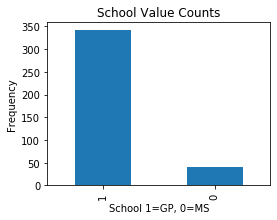

In [21]:
# Visualize distribution school value counts
fig, ax = plt.subplots(1, sharey=True, figsize=(4, 3))
counts = mat_students['school'].value_counts()
print("Value Counts: GP={}, MS={}" .format(counts[1],counts[0]))
mat_students['school'].value_counts().plot(ax=ax, kind='bar', xlabel='School 1=GP, 0=MS', ylabel='Frequency', title='School Value Counts')
plt.show()

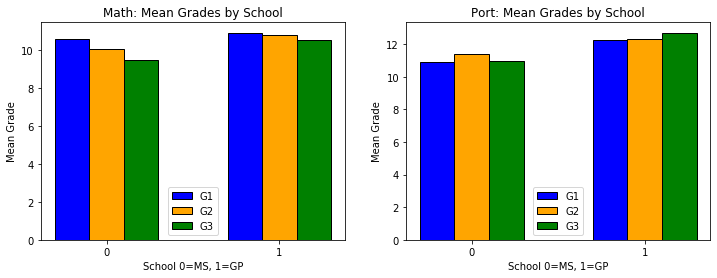

In [22]:
# Plot grouped bar charts for school vs mean grades
gs = gridspec.GridSpec(1, 2)
fig = plt.figure(figsize=(12,4))
width = 0.2
school = [1, 0]

# Math class
ax = fig.add_subplot(gs[0])
for x in school:
    y1 = mat_students.loc[mat_students['school'] == x]['G1'].mean()
    y2 = mat_students.loc[mat_students['school'] == x]['G2'].mean()
    y3 = mat_students.loc[mat_students['school'] == x]['G3'].mean()
    plt.bar(x-width, y1, width, color='blue', edgecolor='black') 
    plt.bar(x, y2, width, color='orange', edgecolor='black') 
    plt.bar(x+width, y3, width, color='green', edgecolor='black') 
plt.legend(["G1", "G2", "G3"], loc='lower center') 
plt.xticks(school) 
ax.set_xlabel('School 0=MS, 1=GP')
ax.set_ylabel('Mean Grade')
ax.set_title("Math: Mean Grades by School")

# Port class
ax = fig.add_subplot(gs[1])
for x in school:
    y1 = por_students.loc[por_students['school'] == x]['G1'].mean()
    y2 = por_students.loc[por_students['school'] == x]['G2'].mean()
    y3 = por_students.loc[por_students['school'] == x]['G3'].mean()
    plt.bar(x-width, y1, width, color='blue', edgecolor='black') 
    plt.bar(x, y2, width, color='orange', edgecolor='black') 
    plt.bar(x+width, y3, width, color='green', edgecolor='black') 
plt.legend(["G1", "G2", "G3"], loc='lower center') 
plt.xticks(school) 
ax.set_xlabel('School 0=MS, 1=GP')
ax.set_ylabel('Mean Grade')
ax.set_title("Port: Mean Grades by School")

plt.show()

## Significance Testing Using Independent T-Test Comparing Mean Grades Across Schools

In [23]:
grades = ['G1', 'G2', 'G3']

# Independent T-test Comparing Means Grades Across Schools
data = []
for grade in grades:
    x1 = mat_students.loc[mat_students['school'] == 1][grade]
    x2 = mat_students.loc[mat_students['school'] == 0][grade]
    ttests = [stats.ttest_ind(x1,x2, equal_var=False)[1]]
    data.append(['Math',round(x1.mean(),2), round(x2.mean(),2), grade, round(ttests[0], 2), '*' if ttests[0] < 0.05 else ''])
for grade in grades:
    x1 = por_students.loc[por_students['school'] == 1][grade]
    x2 = por_students.loc[por_students['school'] == 0][grade]
    ttests = [stats.ttest_ind(x1,x2, equal_var=False)[1]]
    data.append(['Port',round(x2.mean(),2), round(x1.mean(),2), grade, round(ttests[0], 2), '*' if ttests[0] < 0.05 else ''])

pd.DataFrame(data, columns=['Subject', 'School 0 (MS) Mean Grade', 'School 1 (GP) Mean Grade', 'Grade', 'p-value', '|< 0.05|'])

,Subject,School 0 (MS) Mean Grade,School 1 (GP) Mean Grade,Grade,p-value,|< 0.05|
0,Math,10.90,10.55,G1,0.55,
1,Math,10.79,10.05,G2,0.22,
2,Math,10.49,9.47,G3,0.20,
3,Port,10.88,12.26,G1,0.02,*
4,Port,11.40,12.34,G2,0.08,
5,Port,10.95,12.70,G3,0.03,*


## Multiple Regression of Academic Features vs G3

In [28]:
# function to train and predict using linear regression model
def predict(table, columns):
    x = table[columns]
    y = table['G3']
    # split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, 
                                                        random_state=42)
    # fit model on training sets
    sk_model = LinearRegression().fit(X_train, y_train) 
    # print intercept value
    print('Intercept:', round(sk_model.intercept_, 2)) 
    
    cols = pd.DataFrame(x.columns, columns=['Columns'])
    coef = pd.DataFrame(sk_model.coef_.T, columns=['Coefficients'])
    
    # Calculate p-values for independent variables
    model_p = smf.ols(formula = 'G3 ~ '+' + '.join(columns), data=table).fit()
    p_vals = round(model_p.summary2().tables[1]['P>|t|'][1:], 2)
    vals = []
    for i in range(0,len(p_vals)):
        vals.append(p_vals[i])
    p_vals_df = pd.DataFrame(vals, columns=['p-value'])
    vals_strings = []
    for x in vals:
        vals_strings.append('*' if x < 0.05 else '')
    p_val_strings_df = pd.DataFrame(vals_strings, columns=['|< 0.05|'])
    
    # calculate R-squared value
    print('R-squared:', round(sk_model.score(X_test, y_test), 2))
    
    # return Dataframe output
    return pd.concat([cols['Columns'], round(coef['Coefficients'], 2), p_vals_df, p_val_strings_df], axis=1)

In [25]:
# independent variables
columns =['studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'higher', 'school'] 

In [29]:
predict(mat_students, columns) # predict for Math

Intercept: 8.02
R-squared: 0.2


,Columns,Coefficients,p-value,|< 0.05|
0,studytime,0.03,0.87,
1,failures,-2.00,0.00,*
2,schoolsup,-1.01,0.13,
3,famsup,-0.89,0.09,
4,paid,0.51,0.51,
5,higher,2.82,0.03,*
6,school,0.69,0.07,


In [30]:
predict(por_students, columns) # predict for Port

Intercept: 7.53
R-squared: 0.23


,Columns,Coefficients,p-value,|< 0.05|
0,studytime,0.80,0.00,*
1,failures,-1.04,0.00,*
2,schoolsup,-1.39,0.00,*
3,famsup,0.31,0.47,
4,paid,-0.95,0.05,
5,higher,2.47,0.00,*
6,school,1.39,0.00,*
